[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/lstm_gru.ipynb)
[![License: CC BY-NC-SA 4.0](https://img.shields.io/badge/License-CC%20BY--NC--SA%204.0-lightgrey.svg)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

# LSTM and GRU

We show how to use Keras to create simple, multiple and deep LSTM and GRU models. We will use the same dataset as in the previous notebook, the number of train passengers in Chicago. The dataset contains the daily number of bus and train passengers from 2001 to 2021. We will use the number of train passengers as the target variable.

[LSTM](https://en.wikipedia.org/wiki/Long_short-term_memory) (Long Short-Term Memory) a kind of RNNs that are designed to solve the vanishing and exploding gradient problems and allow storing information from longer sequences. The architecture and equations are shown in the following image (see the course slides for more details):

<img src="https://github.com/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/img/lstm.jpg?raw=1" width="2000">

[GRU](https://en.wikipedia.org/wiki/Gated_recurrent_unit) (Gated Recurrent Unit) is a simpler version of LSTM, which combines the forget and input gates into a single update gate. The architecture and equations are shown in the following image (see the course slides for more details):

<img src="https://github.com/francisco-ortin/data-science-course/blob/main/deep-learning/rnn/img/gru.jpg?raw=1" width="1800">

In [1]:
# make sure the required packages are installed
%pip install pandas numpy seaborn matplotlib scikit-learn keras tensorflow --quiet
# if running in colab, install the required packages and copy the necessary files
directory='data-science-course/deep-learning/rnn'
if get_ipython().__class__.__module__.startswith('google.colab'):
    !git clone --depth 1 https://github.com/francisco-ortin/data-science-course.git  2>/dev/null
    !cp --update {directory}/*.py .
    !mkdir -p img data
    !cp {directory}/data/* data/.
    !cp {directory}/img/* img/.

import tensorflow as tf

import utils

## Data preparation

 We load the dataset and preprocess it, as in the previous notebook (`simple_rnn.ipynb`).

In [2]:
dataset = utils.load_dataset("data/transit.csv")
dataset, scaler = utils.scale_data_and_convert_one_hot(dataset)

## Split the dataset into training, validation and test sets

We split the dataset into training, validation and test sets. We use the first 15 years of data for training, the next 3 years for validation, and the last 2 years for testing.

In [3]:
train_ds = dataset[:"2015-12"]
val_ds = dataset["2016-01":"2018-12"]
test_ds = dataset["2019-01":]

We  create a variable length time series dataset to show how RNNs can be trained with variable-length sequences (random length between 40 and 60 days).

In [4]:
length_from, length_to = 40, 60
X_train, y_train = utils.create_variable_time_series_dataset(train_ds, length_from, length_to)
X_val, y_val = utils.create_variable_time_series_dataset(val_ds, length_from, length_to)
X_test, y_test = utils.create_variable_time_series_dataset(test_ds, length_from, length_to)

We convert the time series X and the target variable y to TensorFlow datasets.

In [5]:
train_set_tf = utils.X_y_to_tensor_slices(X_train, y_train)
val_set_tf = utils.X_y_to_tensor_slices(X_val, y_val)
test_set_tf = utils.X_y_to_tensor_slices(X_test, y_test)
# create the batches of 1
train_set_tf = (train_set_tf.batch(1).prefetch(1))
val_set_tf = val_set_tf.batch(1).prefetch(1)
test_set_tf = test_set_tf.batch(1).prefetch(1)

## LSTM and GRU with a single simple neuron

We create a simple RNN with a single neuron. We compare it with the corresponding LSTM and GRU units.

In [6]:
simple_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 4])  # None = variable length sequence, 4 = number of features in each timestep
])
print("Simple RNN model with one unit:", simple_model.summary())
simple_LST_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(1, input_shape=[None, 4])
])
print("Simple LSTM model with one unit:", simple_LST_model.summary())
simple_GRU_model = tf.keras.Sequential([
    tf.keras.layers.GRU(1, input_shape=[None, 4])
])
print("Simple GRU model with one unit:", simple_GRU_model.summary())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

Simple RNN model with one unit: None


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 1)                   │              24 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24 (96.00 B)

 Trainable params: 24 (96.00 B)

 Non-trainable params: 0 (0.00 B)

Simple LSTM model with one unit: None


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 1)                   │              21 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21 (84.00 B)

 Trainable params: 21 (84.00 B)

 Non-trainable params: 0 (0.00 B)

Simple GRU model with one unit: None


We train the model with the Huber loss function, which is less sensitive to outliers than the mean squared error and widespread for time series. We use the stochastic gradient descent (SGD) optimizer with a learning rate of 0.01 and a momentum of 0.9. We use the mean absolute error (MAE) and the mean absolute percentage error (MAPE) as metrics, which is relative measure expressed as a percentage. We use early stopping to avoid overfitting. The model is trained for 500 epochs tops.

In [7]:
epochs = 500
history_RNN = utils.train_model(simple_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
history_LSTM = utils.train_model(simple_LST_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
history_GRU = utils.train_model(simple_GRU_model, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)

Epoch 1/500
   5417/Unknown 40s 7ms/step - loss: 0.0518 - mae: 0.2122 - mape: 850.0744

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


5427/5427 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 0.0517 - mae: 0.2121 - mape: 849.1987 - val_loss: 0.0260 - val_mae: 0.1822 - val_mape: 76.2045
Epoch 2/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0220 - mae: 0.1549 - mape: 676.6478 - val_loss: 0.0256 - val_mae: 0.1804 - val_mape: 75.2213
Epoch 3/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0219 - mae: 0.1546 - mape: 683.1303 - val_loss: 0.0256 - val_mae: 0.1803 - val_mape: 75.1201
Epoch 4/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0219 - mae: 0.1545 - mape: 683.7812 - val_loss: 0.0256 - val_mae: 0.1803 - val_mape: 75.1095
Epoch 5/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0219 - mae: 0.1545 - mape: 683.8511 - val_loss: 0.0256 - val_mae: 0.1803 - val_mape: 75.1085
Epoch 6/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0219 - mae: 0.1545 - mape: 683.8574 - val_loss: 0.0256 - val_mae: 0.1803 - val_mape: 75.1084
Epoch 7/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - 

We plot the training and validation loss.

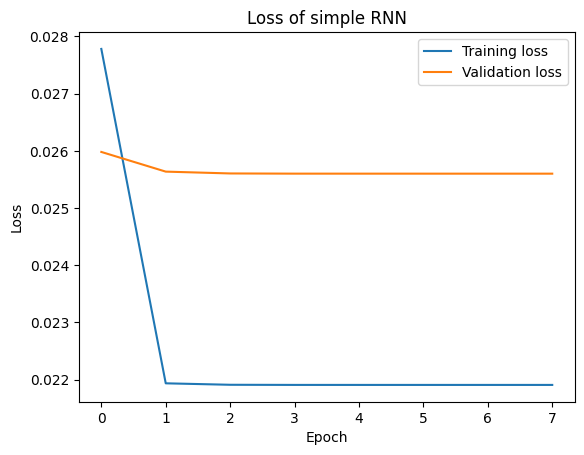

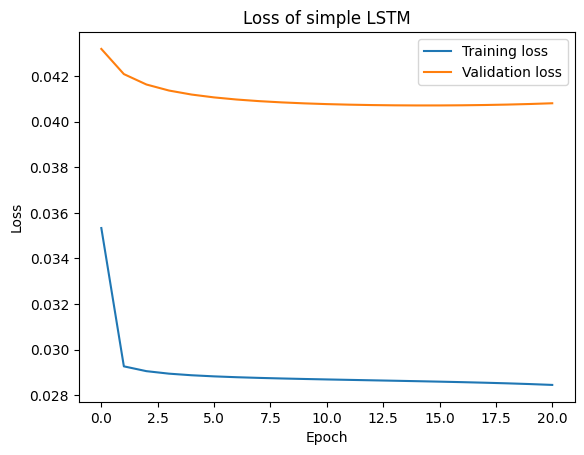

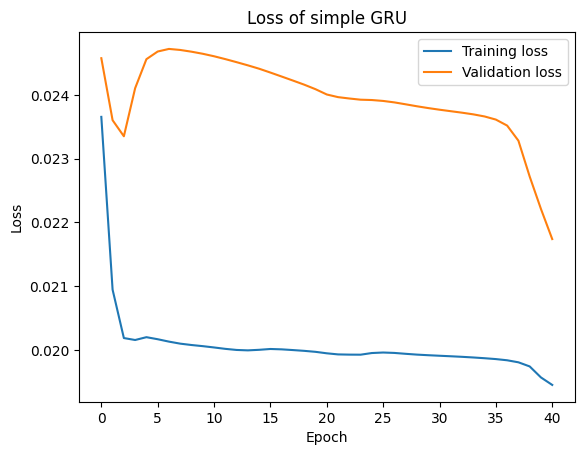

In [8]:
utils.plot_history(history_RNN, "Loss of simple RNN")
utils.plot_history(history_LSTM, "Loss of simple LSTM")
utils.plot_history(history_GRU, "Loss of simple GRU")

We evaluate the model on the test set. Remember that the mean absolute error (MAE) is scaled, so we need to inverse the scaling to get the actual value. That is not necessary for the mean absolute percentage error (MAPE).

In [9]:
test_loss, test_mae, test_mape = simple_model.evaluate(test_set_tf)
print(f"Simple RNN. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = simple_LST_model.evaluate(test_set_tf)
print(f"Simple LSTM. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = simple_GRU_model.evaluate(test_set_tf)
print(f"Simple GRU. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0526 - mae: 0.2476 - mape: 57.4076
Simple RNN. Test MAE: 783098. Test MAPE: 61.26.
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0814 - mae: 0.3364 - mape: 87.2268
Simple LSTM. Test MAE: 835787. Test MAPE: 83.66.
     62/Unknown 0s 3ms/step - loss: 0.0305 - mae: 0.1678 - mape: 51.6223

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0509 - mae: 0.2123 - mape: 50.2079


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Simple GRU. Test MAE: 765674. Test MAPE: 57.42.


Let's take a look at the first few predictions on the test set, to see how our model is performing.

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


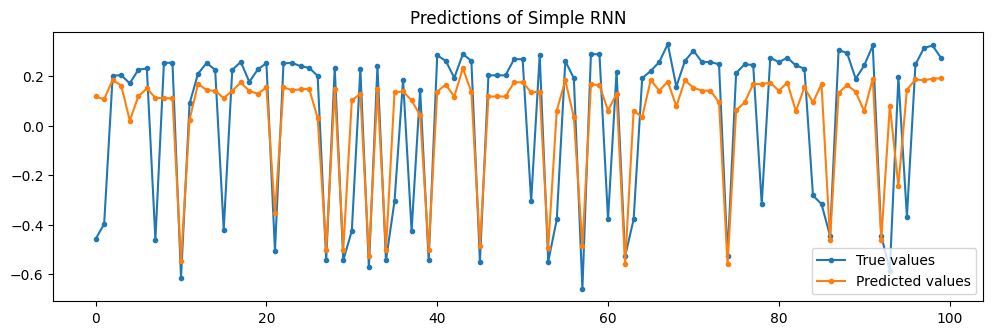

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


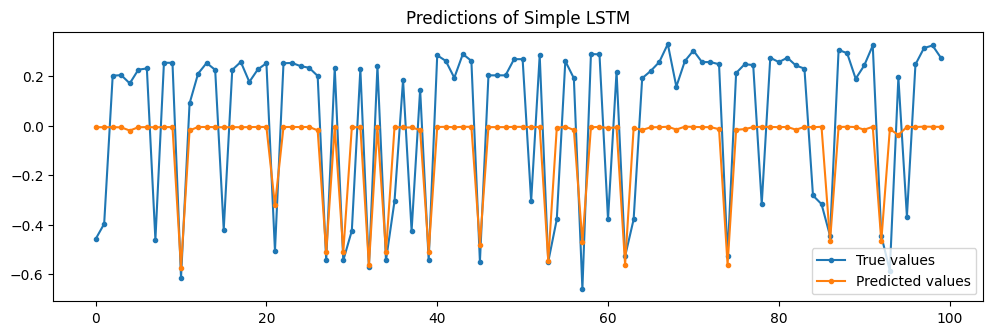

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


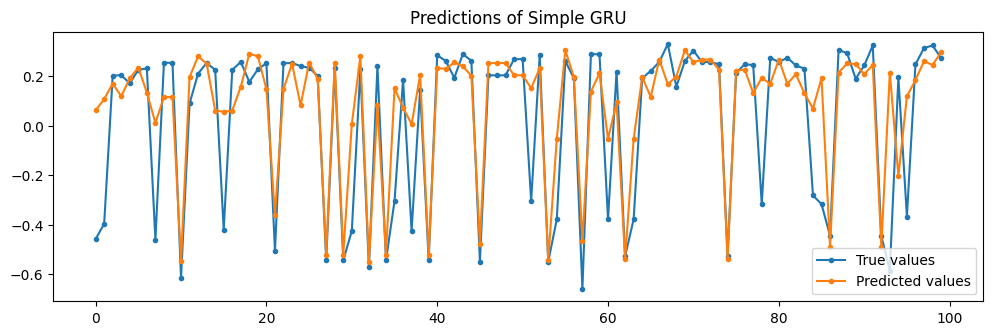

In [10]:
n_instances_to_plot = 100
utils.plot_predictions(y_test, simple_model.predict(test_set_tf), n_instances_to_plot, title="Predictions of Simple RNN")
utils.plot_predictions(y_test, simple_LST_model.predict(test_set_tf), n_instances_to_plot, title="Predictions of Simple LSTM")
utils.plot_predictions(y_test, simple_GRU_model.predict(test_set_tf), n_instances_to_plot, title="Predictions of Simple GRU")

## Multiple simple recurrent neurons

Let's increase model complexity by adding more neurons to the models and a Dense layer at the end.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Multiple neurons with simple RNN units: None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Multiple neurons with simple LSTM units: None


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 32)                  │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,217 (4.75 KB)

 Trainable params: 1,217 (4.75 KB)

 Non-trainable params: 0 (0.00 B)

Multiple neurons with simple GRU units: None
Epoch 1/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 42s 7ms/step - loss: 0.0142 - mae: 0.0980 - mape: 514.9391 - val_loss: 0.0159 - val_mae: 0.1489 - val_mape: 66.1919
Epoch 2/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 25s 5ms/step - loss: 0.0072 - mae: 0.0693 - mape: 480.3084 - val_loss: 0.0138 - val_mae: 0.1345 - val_mape: 60.1700
Epoch 3/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0070 - mae: 0.0680 - mape: 442.6309 - val_loss: 0.0127 - val_mae: 0.1265 - val_mape: 56.4186
Epoch 4/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0069 - mae: 0.0673 - mape: 431.5353 - val_loss: 0.0128 - val_mae: 0.1240 - val_mape: 54.2419
Epoch 5/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0068 - mae: 0.0671 - mape: 421.8785 - val_loss: 0.0122 - val_mae: 0.1233 - val_mape: 55.4731
Epoch 6/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 26s 5ms/step - loss: 0.0068 - mae: 0.0663 - mape: 436.3612 - val_loss: 0.0123 - val_mae: 0.1224 - val_mape: 55.3351
E

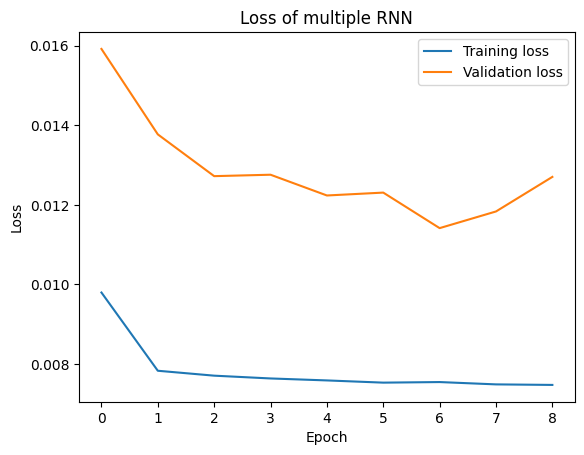

Epoch 1/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0253 - mae: 0.1733 - mape: 667.0951 - val_loss: 0.0357 - val_mae: 0.2345 - val_mape: 92.3725
Epoch 2/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0149 - mae: 0.1289 - mape: 672.9749 - val_loss: 0.0225 - val_mae: 0.1783 - val_mape: 71.5775
Epoch 3/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0119 - mae: 0.1108 - mape: 574.6553 - val_loss: 0.0195 - val_mae: 0.1644 - val_mape: 65.6302
Epoch 4/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0099 - mae: 0.0965 - mape: 539.8340 - val_loss: 0.0236 - val_mae: 0.1842 - val_mape: 72.1010
Epoch 5/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 31s 6ms/step - loss: 0.0082 - mae: 0.0828 - mape: 445.3068 - val_loss: 0.0237 - val_mae: 0.1864 - val_mape: 73.3558


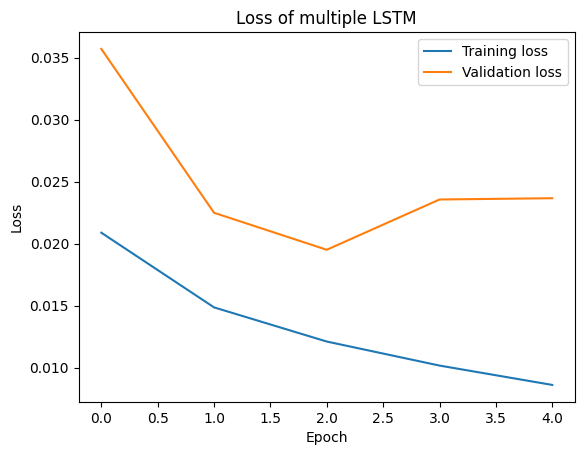

Epoch 1/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 32s 6ms/step - loss: 0.0207 - mae: 0.1528 - mape: 664.9330 - val_loss: 0.0271 - val_mae: 0.2032 - val_mape: 77.4911
Epoch 2/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0143 - mae: 0.1255 - mape: 560.9255 - val_loss: 0.0198 - val_mae: 0.1648 - val_mape: 63.4664
Epoch 3/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.0114 - mae: 0.1055 - mape: 594.2767 - val_loss: 0.0172 - val_mae: 0.1533 - val_mape: 60.2330
Epoch 4/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 29s 5ms/step - loss: 0.0093 - mae: 0.0886 - mape: 447.7746 - val_loss: 0.0160 - val_mae: 0.1494 - val_mape: 61.3108
Epoch 5/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - loss: 0.0077 - mae: 0.0742 - mape: 351.7941 - val_loss: 0.0156 - val_mae: 0.1487 - val_mape: 63.2473
Epoch 6/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 28s 5ms/step - loss: 0.0070 - mae: 0.0676 - mape: 401.1661 - val_loss: 0.0152 - val_mae: 0.1482 - val_mape: 65.3893
Epoch 7/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 29s

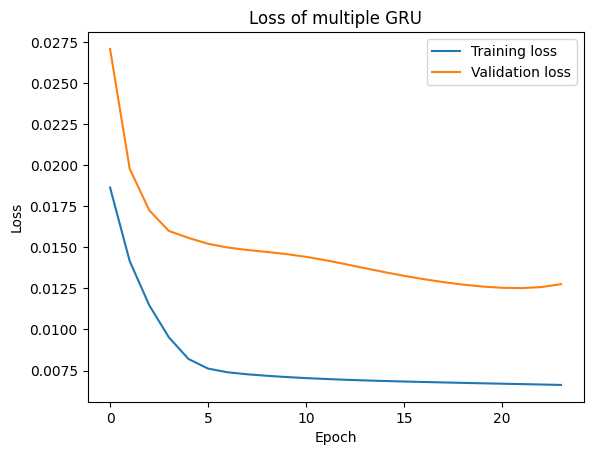

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0298 - mae: 0.1686 - mape: 39.7988
Multiple RNN. Test MAE: 728961. Test MAPE: 45.13.
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0376 - mae: 0.2082 - mape: 52.5510
Multiple LSTM. Test MAE: 746809. Test MAPE: 52.75.
     61/Unknown 0s 3ms/step - loss: 0.0018 - mae: 0.0507 - mape: 20.0865

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0233 - mae: 0.1485 - mape: 35.6093
Multiple GRU. Test MAE: 705951. Test MAPE: 38.24.


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


1008/1008 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


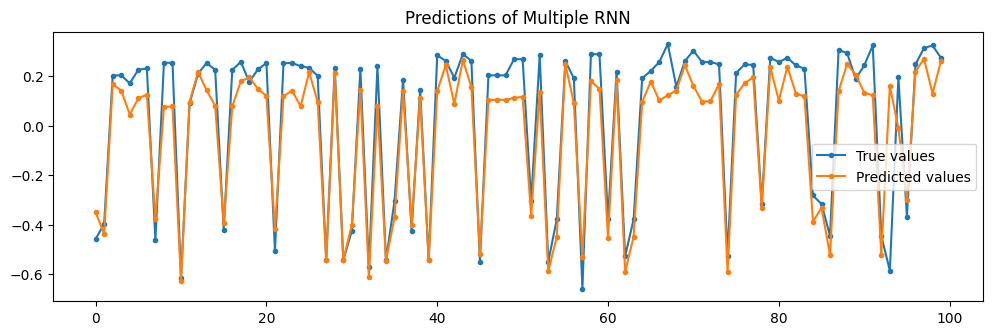

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


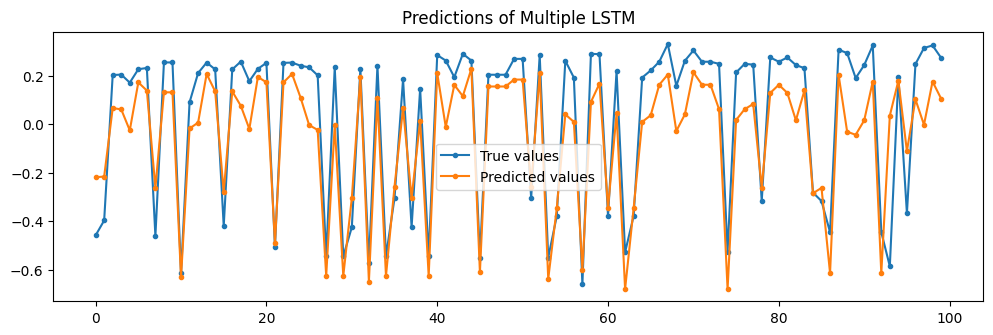

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


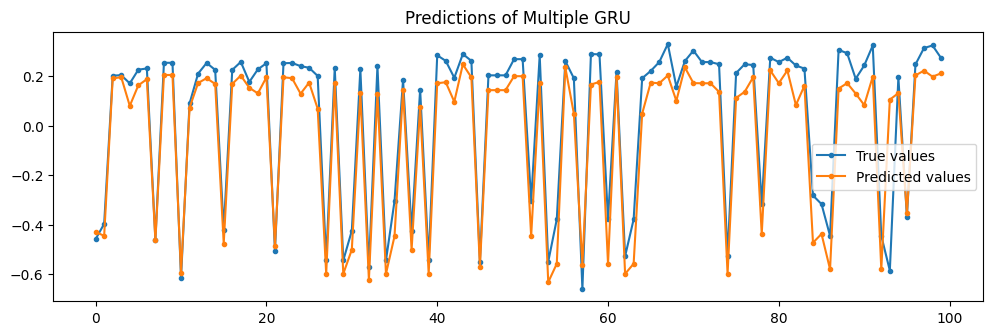

In [11]:
multi_model_RNN = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),  # tanh activation function by default
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Multiple neurons with simple RNN units:", multi_model_RNN.summary())
multi_model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=[None, 4]),  # tanh activation function by default
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Multiple neurons with simple LSTM units:", multi_model_RNN.summary())
multi_model_GRU = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=[None, 4]),  # tanh activation function by default
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Multiple neurons with simple GRU units:", multi_model_RNN.summary())


# train the models
history_RNN = utils.train_model(multi_model_RNN, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_RNN, "Loss of multiple RNN")
history_LSTM = utils.train_model(multi_model_LSTM, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_LSTM, "Loss of multiple LSTM")
history_GRU = utils.train_model(multi_model_GRU, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_GRU, "Loss of multiple GRU")

# evaluate the model
test_loss, test_mae, test_mape = multi_model_RNN.evaluate(test_set_tf)
print(f"Multiple RNN. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = multi_model_LSTM.evaluate(test_set_tf)
print(f"Multiple LSTM. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = multi_model_GRU.evaluate(test_set_tf)
print(f"Multiple GRU. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")

utils.plot_predictions(y_test, multi_model_RNN.predict(test_set_tf), n_instances_to_plot, title="Predictions of Multiple RNN")
utils.plot_predictions(y_test, multi_model_LSTM.predict(test_set_tf), n_instances_to_plot, title="Predictions of Multiple LSTM")
utils.plot_predictions(y_test, multi_model_GRU.predict(test_set_tf), n_instances_to_plot, title="Predictions of Multiple GRU")

## Deep RNN

We increase the complexity further by stacking RNNs. We create a deep RNN with three layers. The last layer is a Dense layer with a single neuron (regression model).

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, None, 32)            │           1,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_3 (SimpleRNN)             │ (None, None, 32)            │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_4 (SimpleRNN)             │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,377 (21.00 KB)

 Trainable params: 5,377 (21.00 KB)

 Non-trainable params: 0 (0.00 B)

Deep model with simple RNN units None


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, None, 32)            │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, None, 32)            │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,409 (83.63 KB)

 Trainable params: 21,409 (83.63 KB)

 Non-trainable params: 0 (0.00 B)

Deep model with LSTM units None


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                          │ (None, None, 32)            │           3,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, None, 32)            │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_4 (GRU)                          │ (None, 32)                  │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,353 (63.88 KB)

 Trainable params: 16,353 (63.88 KB)

 Non-trainable params: 0 (0.00 B)

Deep model with GRU units None
Epoch 1/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 90s 16ms/step - loss: 0.0224 - mae: 0.1345 - mape: 843.8551 - val_loss: 0.1082 - val_mae: 0.4445 - val_mape: 189.8376
Epoch 2/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.0091 - mae: 0.0825 - mape: 501.5292 - val_loss: 0.0369 - val_mae: 0.2369 - val_mape: 98.9041
Epoch 3/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 47s 9ms/step - loss: 0.0082 - mae: 0.0735 - mape: 524.9534 - val_loss: 0.0309 - val_mae: 0.2247 - val_mape: 93.8842
Epoch 4/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 48s 9ms/step - loss: 0.0075 - mae: 0.0693 - mape: 447.4779 - val_loss: 0.0258 - val_mae: 0.1999 - val_mape: 85.6624
Epoch 5/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 46s 9ms/step - loss: 0.0073 - mae: 0.0683 - mape: 433.6494 - val_loss: 0.0252 - val_mae: 0.1966 - val_mape: 83.0971
Epoch 6/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 44s 8ms/step - loss: 0.0072 - mae: 0.0672 - mape: 477.0951 - val_loss: 0.0268 - val_mae: 0.2032 - val_mape: 85.3612
Epoch 7/500
5

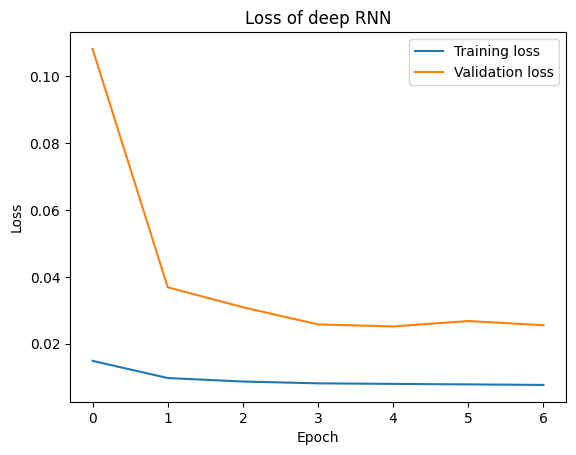

Epoch 1/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - loss: 0.0422 - mae: 0.2442 - mape: 1209.8895 - val_loss: 0.0629 - val_mae: 0.3063 - val_mape: 129.7038
Epoch 2/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 57s 11ms/step - loss: 0.0211 - mae: 0.1577 - mape: 1395.6543 - val_loss: 0.0491 - val_mae: 0.2638 - val_mape: 119.9468
Epoch 3/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 0.0163 - mae: 0.1382 - mape: 1467.9536 - val_loss: 0.0482 - val_mae: 0.2832 - val_mape: 124.0704
Epoch 4/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 53s 10ms/step - loss: 0.0089 - mae: 0.0833 - mape: 536.0482 - val_loss: 0.0411 - val_mae: 0.2606 - val_mape: 109.2710
Epoch 5/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 0.0078 - mae: 0.0737 - mape: 414.7217 - val_loss: 0.0375 - val_mae: 0.2465 - val_mape: 103.3718
Epoch 6/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 0.0076 - mae: 0.0721 - mape: 389.0387 - val_loss: 0.0340 - val_mae: 0.2339 - val_mape: 100.8549
Epoch 7/500
5427/5427 ━━━━━━━━━━━

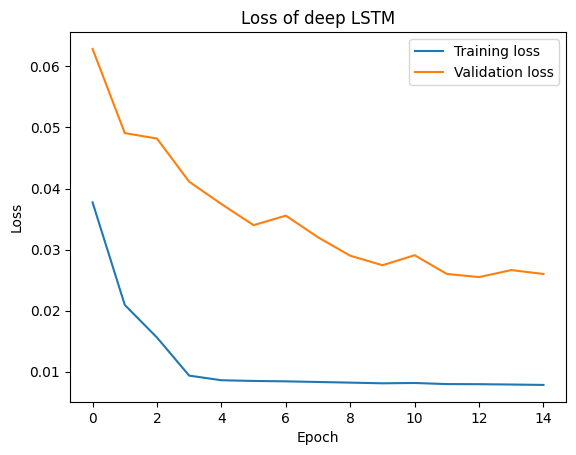

Epoch 1/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 53s 9ms/step - loss: 0.0293 - mae: 0.1884 - mape: 889.6641 - val_loss: 0.0338 - val_mae: 0.2152 - val_mape: 91.7244
Epoch 2/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 0.0142 - mae: 0.1243 - mape: 920.5852 - val_loss: 0.0283 - val_mae: 0.2096 - val_mape: 84.4837
Epoch 3/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 0.0095 - mae: 0.0870 - mape: 457.4492 - val_loss: 0.0216 - val_mae: 0.1801 - val_mape: 73.6043
Epoch 4/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 52s 10ms/step - loss: 0.0084 - mae: 0.0768 - mape: 490.5235 - val_loss: 0.0189 - val_mae: 0.1665 - val_mape: 72.0512
Epoch 5/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 51s 9ms/step - loss: 0.0077 - mae: 0.0708 - mape: 414.0227 - val_loss: 0.0179 - val_mae: 0.1605 - val_mape: 73.3355
Epoch 6/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 54s 10ms/step - loss: 0.0073 - mae: 0.0670 - mape: 406.3848 - val_loss: 0.0176 - val_mae: 0.1587 - val_mape: 74.4462
Epoch 7/500
5427/5427 ━━━━━━━━━━━━━━━━━━━━ 

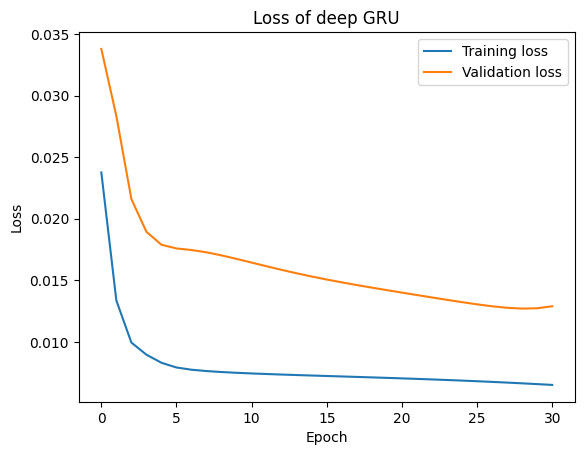

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0701 - mae: 0.2744 - mape: 63.7217
Deep RNN. Test MAE: 818879. Test MAPE: 71.58.
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.1222 - mae: 0.3196 - mape: 61.3344


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Deep LSTM. Test MAE: 907414. Test MAPE: 91.13.
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0492 - mae: 0.2007 - mape: 40.7943


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


Deep GRU. Test MAE: 778350. Test MAPE: 55.85.
1008/1008 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


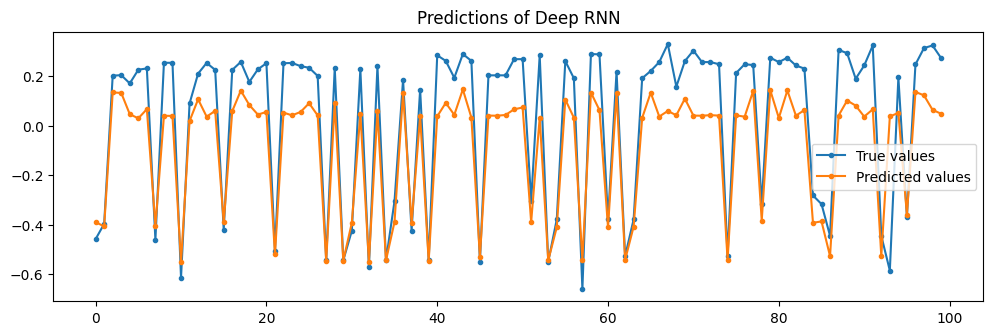

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


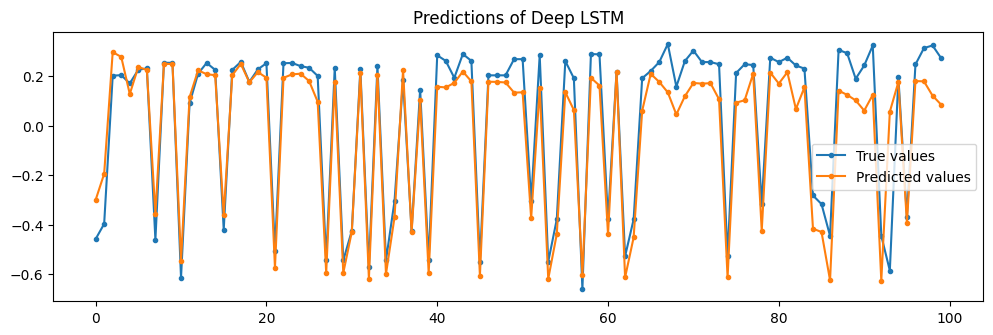

1008/1008 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step


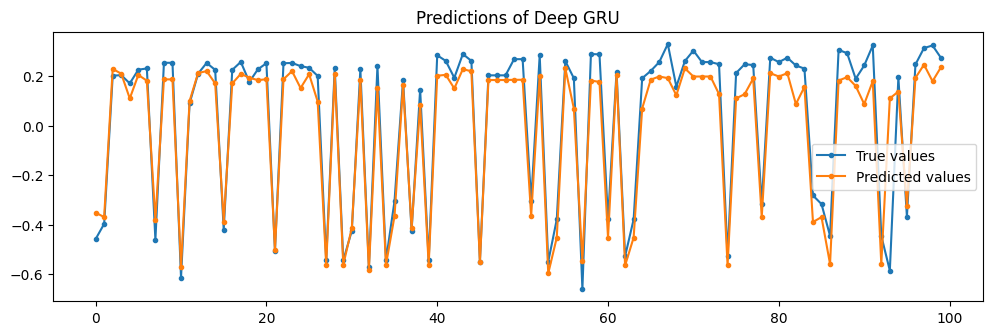

In [12]:
deep_model_RNN = tf.keras.Sequential([
    # return_sequences=True is used to return the output of each time step, not just the last one
    # in this way, the next layer can process the output of each time step (they can be stacked)
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Deep model with simple RNN units", deep_model_RNN.summary())
deep_model_LSTM = tf.keras.Sequential([
    tf.keras.layers.LSTM(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.LSTM(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Deep model with LSTM units", deep_model_LSTM.summary())
deep_model_GRU = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=[None, 4], return_sequences=True),
    tf.keras.layers.GRU(32, return_sequences=True),
    tf.keras.layers.GRU(32, input_shape=[None, 4]),
    tf.keras.layers.Dense(1)  # no activation function by default (regression model)
])
print("Deep model with GRU units", deep_model_GRU.summary())

# train the model
history_RNN = utils.train_model(deep_model_RNN, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_RNN, "Loss of deep RNN")
history_LSTM = utils.train_model(deep_model_LSTM, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_LSTM, "Loss of deep LSTM")
history_GRU = utils.train_model(deep_model_GRU, train_set_tf, val_set_tf, learning_rate=0.01, epochs=epochs)
utils.plot_history(history_GRU, "Loss of deep GRU")


# evaluate the model
test_loss, test_mae, test_mape = deep_model_RNN.evaluate(test_set_tf)
print(f"Deep RNN. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = deep_model_LSTM.evaluate(test_set_tf)
print(f"Deep LSTM. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")
test_loss, test_mae, test_mape = deep_model_GRU.evaluate(test_set_tf)
print(f"Deep GRU. Test MAE: {scaler.inverse_transform([[test_mae]])[0][0]:.0f}. Test MAPE: {test_mape:.2f}.")

# plot the first few predictions on the test set
utils.plot_predictions(y_test, deep_model_RNN.predict(test_set_tf), n_instances_to_plot, title="Predictions of Deep RNN")
utils.plot_predictions(y_test, deep_model_LSTM.predict(test_set_tf), n_instances_to_plot, title="Predictions of Deep LSTM")
utils.plot_predictions(y_test, deep_model_GRU.predict(test_set_tf), n_instances_to_plot, title="Predictions of Deep GRU")

## ✨ Questions ✨

1. Are single-unit LSTM and GRU models improving the simple one? Why?
2. Are multiple and deep LSTM and GRU models improving the single-unit ones? Why?
3. What should be done to improve multiple and deep LSTM and GRU models?

### Answers

*Write your answers here.*

